In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2025'])
args.prep_scale = False
args.sh_weights = True
args.max_epoch = 1000
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/1-DLPFC/'
CPS.set_random_seed(args.seed)
args

Namespace(batch_size=256, clusters=7, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/1-DLPFC/', decoder='ZINB', decoder_latent=[256, 512], distill=1.0, dropout=0.2, flow='source_to_target', freq=32, gpu=0, hvgs=2000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=6, n_spot=0, num_heads=4, prep_scale=False, radius=150, seed=2025, self_loops=True, sh_weights=True, sigma=3.0, visual=True, weight_decay=0.0001)

In [4]:
section = '151673'
adata = sc.read_visium(os.path.join(args.dataset_path+section))
Ann_df = pd.read_csv(os.path.join(args.dataset_path+'1-DLPFC_annotations/', section+'_truth.txt'), 
                     sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
sc.pp.normalize_total(adata, target_sum=1e4)
adata.layers["counts"] = adata.X.copy()
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=True, max_value=10)

adata_hvg = adata[:, adata.var['highly_variable']].copy()
counts_layer = adata_hvg.layers['counts']

adata.obsm['hvg_features'] = adata_hvg.X
adata.obsm['hvg_counts'] = counts_layer.toarray()

In [6]:
spatial_data = CPS.SpatialGraphBuilder(args)
train_data, test_data, train_indices, test_indices = spatial_data.spots_perturb(adata, mask_ratio=0.5)
print(train_data)

Data(x=[1820, 2000], edge_index=[2, 15392], y=[1820, 2000], pos=[1820, 2], num_nodes=1820, num_genes=2000)


In [7]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(train_data)

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch   0: Train[Total:8.8459, T:4.0306, S:4.0297, D:0.7855]

Epoch  10: Train[Total:5.5061, T:2.4791, S:2.4823, D:0.5447]

Epoch  20: Train[Total:3.9611, T:1.7465, S:1.7774, D:0.4372]

Epoch  30: Train[Total:3.2474, T:1.3895, S:1.4198, D:0.4381]

Epoch  40: Train[Total:2.8699, T:1.2185, S:1.2539, D:0.3975]

Epoch  50: Train[Total:2.7393, T:1.1711, S:1.2146, D:0.3536]

Epoch  60: Train[Total:2.7004, T:1.1542, S:1.1971, D:0.3491]

Epoch  70: Train[Total:2.6581, T:1.1386, S:1.1806, D:0.3389]

Epoch  80: Train[Total:2.6323, T:1.1248, S:1.1646, D:0.3429]

Epoch  90: Train[Total:2.6008, T:1.1139, S:1.1551, D:0.3319]

Epoch 100: Train[Total:2.5839, T:1.1034, S:1.1438, D:0.3367]

Epoch 110: Train[Total:2.5815, T:1.0938, S:1.1346, D:0.3531]

Epoch 120: Train[Total:2.5600, T:1.0844, S:1.1240, D:0.3516]

Epoch 130: Train[Total:2.5517, T:1.0729, S:1.1155, D:0.3633]

Epoch 140: Train[Total:2.5331, T:1.0630, S:1.1064, D:0.3637]

Epoch 150: Train[Total:2.5145, T:1.0513, S:1.0982, D:0.3650]

Epoch 1

In [10]:
cps_model.model

CPSModel(
  (teacher): TeacherNicheAttention(
    (multi_scale_convs): MultiHopSSGConv(
      (convs): ModuleList(
        (0): SSGConv(2000, 64, K=0, alpha=0.2)
        (1): SSGConv(2000, 64, K=1, alpha=0.2)
        (2): SSGConv(2000, 64, K=2, alpha=0.2)
        (3): SSGConv(2000, 64, K=3, alpha=0.2)
        (4): SSGConv(2000, 64, K=4, alpha=0.2)
        (5): SSGConv(2000, 64, K=5, alpha=0.2)
        (6): SSGConv(2000, 64, K=6, alpha=0.2)
        (7): SSGConv(2000, 64, K=7, alpha=0.2)
      )
      (norms): ModuleList(
        (0-7): 8 x BatchNorm(64)
      )
      (dropout): Dropout(p=0.2, inplace=False)
      (activation): GELU(approximate='none')
    )
    (query_proj): Linear(in_features=64, out_features=64, bias=True)
    (key_proj): Linear(in_features=64, out_features=64, bias=True)
    (value_proj): Linear(in_features=64, out_features=64, bias=True)
    (out_proj): Linear(in_features=64, out_features=64, bias=True)
    (residual): Identity()
    (dropout): Dropout(p=0.2, inplac

In [8]:
metrics = cps_model.evaluate_spots_imputation(test_data=test_data, test_indices=test_indices, experiment_name='DLPFC_SI')

TypeError: evaluate_spots_imputation() got an unexpected keyword argument 'test_indices'

In [ ]:
train_adata = adata[train_indices]
test_adata = adata[test_indices]

In [ ]:
test_adata

View of AnnData object with n_obs × n_vars = 1819 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'hvg_features', 'hvg_counts'
    layers: 'counts'

In [ ]:
train_adata

View of AnnData object with n_obs × n_vars = 1820 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'hvg_features', 'hvg_counts'
    layers: 'counts'

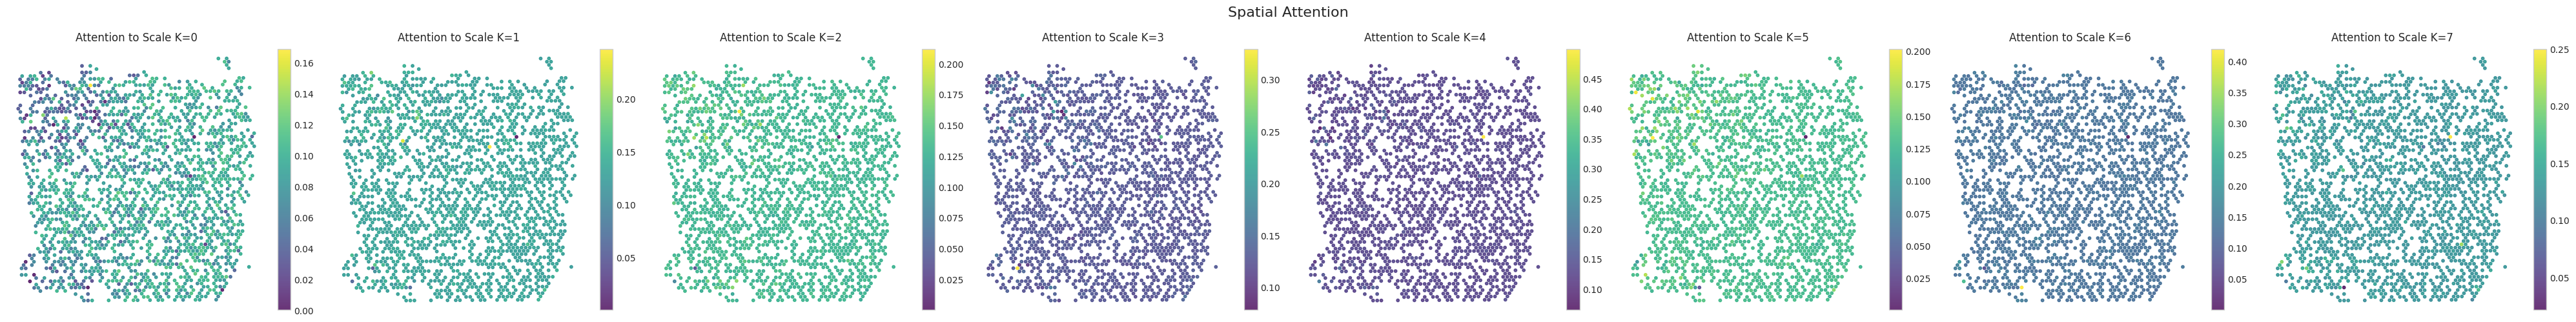

In [ ]:
z_s, latent, attn, fig = cps_model.interpret_attn_scores(train_data, return_fig=True)
train_adata.obsm['z_s'] = z_s
train_adata.obsm['z_t'] = latent

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


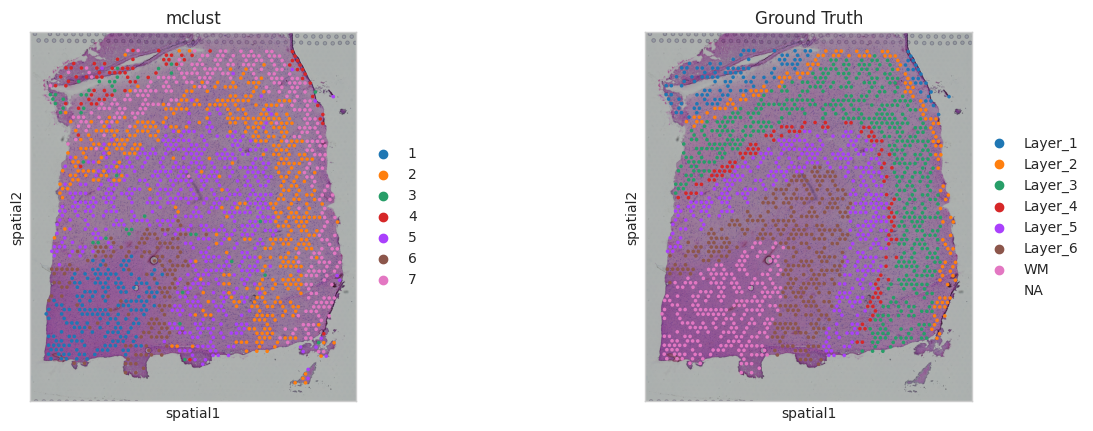

In [ ]:
train_adata = CPS.mclust(train_adata, args, key='z_s', pca_dim=32)
sc.pl.spatial(train_adata, img_key="hires", color=["mclust", 'Ground Truth'])

fitting ...
  |======================================================================| 100%


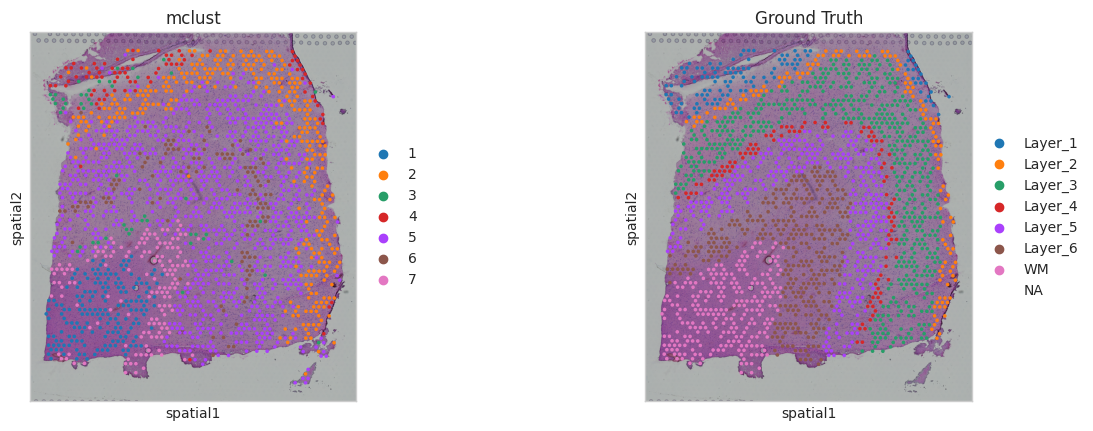

In [ ]:
train_adata = CPS.mclust(train_adata, args, key='z_t', pca_dim=32)
sc.pl.spatial(train_adata, img_key="hires", color=["mclust",'Ground Truth'])